* ## Unet 
* ## train/val/test dataset 128x128 
* ## repeat runs of modelling to change initialisation each time

In [1]:
import os
import torch
import numpy as np
import pandas as pd

import pickle
import time

import cv2
# import dlib
# face_detector = dlib.get_frontal_face_detector()
# shape predictor from http://dlib.net/files/shape_predictor_68_face_landmarks.dat.bz2
# landmark_detector = dlib.shape_predictor("shape_predictor_68_face_landmarks.dat")

from torch.utils.data import DataLoader, Dataset
import torch.nn as nn
import torch.nn.functional as F
import torchvision


from PIL import Image
from matplotlib import pyplot as plt

from torchinfo import summary

In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

In [3]:
# set reandom seeds to allow repeat test comparisons
import random
torch.backends.cudnn.deterministic = True
random.seed(42)
torch.manual_seed(42)
torch.cuda.manual_seed(42)
np.random.seed(42)

# Load Images and Landmarks

In [4]:
pickle_dir = './inputs/pickles/v05/'
# load landmarks
with open(pickle_dir + 'resized_lmarks_train_v05.pickle', 'rb') as handle:
    lmarks_train = pickle.load(handle)
with open(pickle_dir + 'resized_lmarks_val_v05.pickle', 'rb') as handle:
    lmarks_val = pickle.load(handle)    
with open(pickle_dir + 'resized_lmarks_test_v05.pickle', 'rb') as handle:
    lmarks_test = pickle.load(handle)
    
# load images
with open(pickle_dir + 'resized_imgs_train_v05.pickle', 'rb') as handle:
    images_train = pickle.load(handle)
with open(pickle_dir + 'resized_imgs_val_v05.pickle', 'rb') as handle:
    images_val = pickle.load(handle)
with open(pickle_dir + 'resized_imgs_test_v05.pickle', 'rb') as handle:
    images_test = pickle.load(handle)


In [5]:
print(len(lmarks_train))
print(len(images_train))

print(len(lmarks_val))
print(len(images_val))

print(len(lmarks_test))
print(len(images_test))

5995
5995
1497
1497
1633
1633


In [6]:
def vis_images(img_list, landmarks_list, first_img, nrows, ncols):
    '''plot landmarks on images given a list of both and first index on list
     to plot together with number of rows and columns'''
    fig, ax = plt.subplots(nrows, ncols, figsize=(ncols+5, nrows+5)) # create figure
    plt.setp(plt.gcf().get_axes(), xticks=[], yticks=[]); # turn off all axes ticks
    idx_plt = 0
    for row in range(nrows):
        for col in range(ncols):
            img = img_list[idx_plt+first_img].copy()
            landmark_tuples = landmarks_list[idx_plt+first_img]
            for n in range(0,68):
                try:
                    x=int(landmark_tuples[n][0])
                    y=int(landmark_tuples[n][1])
                    # print(x,y)
                    cv2.circle(img, (x, y), 1, (255, 255, 255), -1)
                except:
                    pass
                
            # cv2.circle(img, (10, 10), 1, (255, 255, 255), 10)
            if nrows == 1 or ncols == 1:
                ax[idx_plt].imshow(img)
            else:
                ax[row][col].imshow(img)
            idx_plt+= 1
            
    plt.tight_layout()
    plt.show()

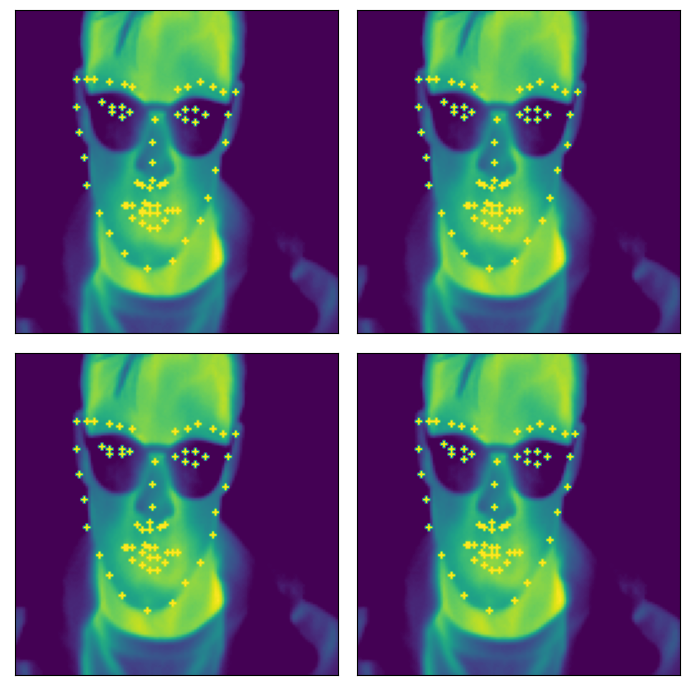

In [7]:
vis_images(images_train, lmarks_train, 4200, 2, 2)

# Generate Ground Truth Images from Landmarks

In [8]:
def simple_scale(array):
    '''simple scale to put amplitudes between 0 and 1. Better scaling based on 
    min/max/std dev for several images may help - need to see Bentley data'''
    return (array - array.min()) / (array.max() - array.min())

In [9]:
def landmark_gtruth_gen(landmarks_list):
    '''take landmark locations and generate map by adding a 1 at the centre of a landmark and 
    gradually reducing amplitudes to surrounding pixels, then adding all these maps together'''
    gtruth_list = []
    
    for i, lms in enumerate(landmarks_list):
        gtruth_map = np.zeros([128,128])
        
        for lm in lms:
            l_col = lm[0]
            l_row = lm[1]
            l_map = np.zeros([128,128])
            # create matrix of abs distance of each pixel from the current row location of the landmark 
            row_dist_map = np.array([np.abs(np.arange(128) - l_row),]*128).T
            # create matrix of abs distance of each pixel from the current col location of the landmark 
            col_dist_map = np.array([np.abs(np.arange(128) - l_col),]*128)
            # take the max distance from either row or column of the landmark 
            l_map = 0.5**(np.maximum(row_dist_map, col_dist_map))
            # add map of each landmark to full map of all landmarks
            gtruth_map += l_map
            
        # scale to between 0 and 1
        gtruth_map = simple_scale(gtruth_map)
            
        gtruth_list.append(gtruth_map)
        
        if i%1000 == 0:
            print('step:', str(i))
            
        
    return gtruth_list        

In [10]:
start_time = time.time()
gt_lmarks_train = landmark_gtruth_gen(lmarks_train)
# gtruth_lm_list_val = landmark_gtruth_gen(landmarks_list_val)
print("runtime:", time.time() - start_time)

step: 0
step: 1000
step: 2000
step: 3000
step: 4000
step: 5000
runtime: 357.0885775089264


In [11]:
start_time = time.time()
gt_lmarks_val = landmark_gtruth_gen(lmarks_val)
# gtruth_lm_list_val = landmark_gtruth_gen(landmarks_list_val)
print("runtime:", time.time() - start_time)

step: 0
step: 1000
runtime: 89.77161908149719


In [12]:
start_time = time.time()
gt_lmarks_test = landmark_gtruth_gen(lmarks_test)
# gtruth_lm_list_val = landmark_gtruth_gen(landmarks_list_val)
print("runtime:", time.time() - start_time)

step: 0
step: 1000
runtime: 95.13035702705383


In [ ]:
## load gtruth landmarks
#with open('./pickles/gtruth_lm_list_train_v04.pickle', 'rb') as handle:
#    gt_lmarks_train = pickle.load(handle)
#    
#with open('./pickles/gtruth_lm_list_val_v04.pickle', 'rb') as handle:
#    gt_lmarks_val = pickle.load(handle)
#    
#with open('./pickles/gtruth_lm_list_test_v04.pickle', 'rb') as handle:
#    gt_lmarks_test = pickle.load(handle)

In [13]:
# export gtruth landmarks
with open('./pickles/gtruth_lm_list_train_v05.pickle', 'wb') as handle:
    pickle.dump(gt_lmarks_train, handle)

with open('./pickles/gtruth_lm_list_val_v05.pickle', 'wb') as handle:
    pickle.dump(gt_lmarks_val, handle)

with open('./pickles/gtruth_lm_list_test_v05.pickle', 'wb') as handle:
    pickle.dump(gt_lmarks_test, handle)

In [14]:
def vis_gtruth(img_list, first_img, nrows, ncols):
    fig, ax = plt.subplots(nrows, ncols, figsize=(ncols+5, nrows+5)) # create figure
    plt.setp(plt.gcf().get_axes(), xticks=[], yticks=[]); # turn off all axes ticks
    idx_plt = 0
    for row in range(nrows):
        for col in range(ncols):
            img = img_list[idx_plt+first_img].copy()
            if nrows == 1 or ncols == 1:
                ax[idx_plt].imshow(img)
                # ax[idx_plt].set_title(filenames_list[idx_plt+first_img])
            else:
                ax[row][col].imshow(img)
                # ax[row][col].set_title(filenames_list[idx_plt+first_img])
            idx_plt+= 1
            
    plt.tight_layout()
    plt.show()

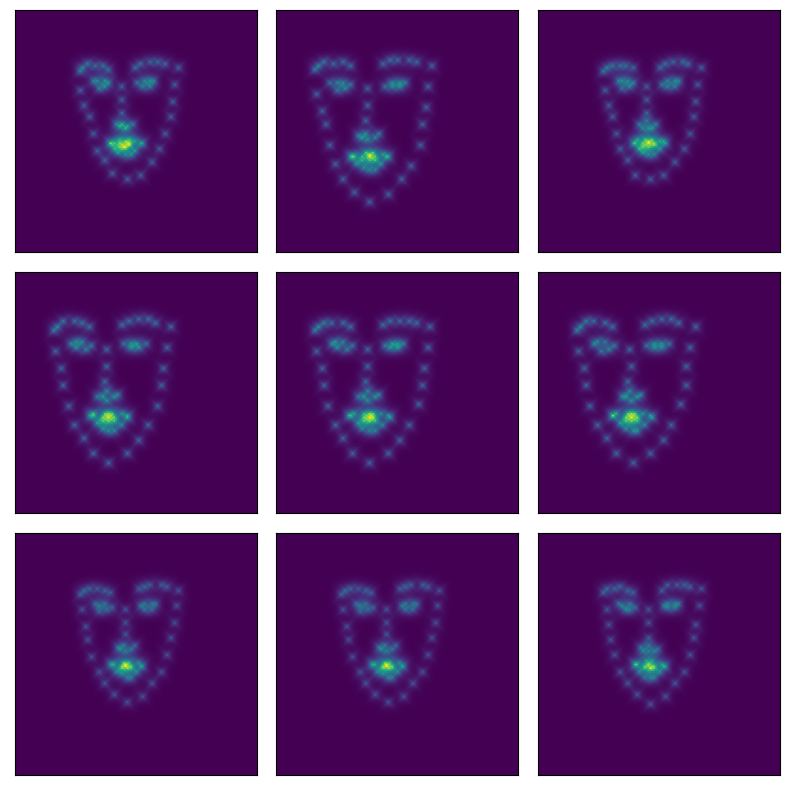

In [15]:
vis_gtruth(gt_lmarks_train, 4000, 3, 3)

# Prepare Tensors for network

In [16]:
def simple_scale(array):
    '''simple scale to put amplitudes between 0 and 1. Better scaling based on 
    min/max/std dev for several images may help - need to see Bentley data'''
    return (array - array.min()) / (array.max() - array.min())

# def data_prep(img_list):
#     # scale images to between 0 and 1
#     scaled_images = [simple_scale(x) for x in img_list]
#     # move the channel axis from last to first for each image
#     prep_list = torch.tensor([np.moveaxis(x, -1,0) for x in scaled_images])
#     return prep_list

def data_prep(img_list):
    # scale images to between 0 and 1
    scaled_images = [simple_scale(x) for x in img_list]
    # move the channel axis from last to first for each image
    prep_list = torch.tensor([np.expand_dims(x, axis=0) for x in scaled_images])
    return prep_list

In [17]:
train_tensors = data_prep(images_train)
val_tensors = data_prep(images_val)
test_tensors = data_prep(images_test)

In [18]:
train_tensors.shape

torch.Size([5995, 1, 128, 128])

In [19]:
images_train[0].max()

255

In [20]:
gt_lmarks_train[0].max()

1.0

In [21]:
gtruth_train_tensors = torch.tensor(gt_lmarks_train)
gtruth_train_tensors = gtruth_train_tensors[:,None,:,:]

train_ds = torch.utils.data.TensorDataset(train_tensors, gtruth_train_tensors)
train_dl = DataLoader(train_ds, batch_size=16, shuffle=True)

gtruth_val_tensors = torch.tensor(gt_lmarks_val)
gtruth_val_tensors = gtruth_val_tensors[:,None,:,:]

# Not shuffling validation set as not necessary
val_ds = torch.utils.data.TensorDataset(val_tensors, gtruth_val_tensors)
val_dl = DataLoader(val_ds, batch_size=16, shuffle=False)

gtruth_test_tensors = torch.tensor(gt_lmarks_test)
gtruth_test_tensors = gtruth_test_tensors[:,None,:,:]

# Not shuffling validation set as not necessary
test_ds = torch.utils.data.TensorDataset(test_tensors, gtruth_test_tensors)
test_dl = DataLoader(test_ds, batch_size=16, shuffle=False)

## Basic Unet

In [22]:
class conv_block(nn.Module):
    """
    Convolution Block 
    """
    def __init__(self, in_ch, out_ch):
        super(conv_block, self).__init__()
        
        self.conv = nn.Sequential(
            nn.Conv2d(in_ch, out_ch, kernel_size=3, stride=1, padding=1, bias=True),
            nn.BatchNorm2d(out_ch),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_ch, out_ch, kernel_size=3, stride=1, padding=1, bias=True),
            nn.BatchNorm2d(out_ch),
            nn.ReLU(inplace=True))

    def forward(self, x):

        x = self.conv(x)
        return x


class up_conv(nn.Module):
    """
    Up Convolution Block
    """
    def __init__(self, in_ch, out_ch):
        super(up_conv, self).__init__()
        self.up = nn.Sequential(
            nn.Upsample(scale_factor=2),
            nn.Conv2d(in_ch, out_ch, kernel_size=3, stride=1, padding=1, bias=True),
            nn.BatchNorm2d(out_ch),
            nn.ReLU(inplace=True)
        )

    def forward(self, x):
        x = self.up(x)
        return x

class UNet_small(nn.Module):
    """
    UNet - Basic Implementation
    Paper : https://arxiv.org/abs/1505.04597
    """
    def __init__(self, in_ch=1, out_ch=1):
        super(UNet_small, self).__init__()

        n1 = 64
        filters = [n1, n1 * 2, n1 * 4, n1 * 8]
        
        self.Maxpool1 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.Maxpool2 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.Maxpool3 = nn.MaxPool2d(kernel_size=2, stride=2)

        self.Conv1 = conv_block(in_ch, filters[0])
        self.Conv2 = conv_block(filters[0], filters[1])
        self.Conv3 = conv_block(filters[1], filters[2])
        self.Conv4 = conv_block(filters[2], filters[3])

        self.Up4 = up_conv(filters[3], filters[2])
        self.Up_conv4 = conv_block(filters[3], filters[2])

        self.Up3 = up_conv(filters[2], filters[1])
        self.Up_conv3 = conv_block(filters[2], filters[1])

        self.Up2 = up_conv(filters[1], filters[0])
        self.Up_conv2 = conv_block(filters[1], filters[0])

        self.Conv = nn.Conv2d(filters[0], out_ch, kernel_size=1, stride=1, padding=0)

       # self.active = torch.nn.Sigmoid()

    def forward(self, x):

        e1 = self.Conv1(x)

        e2 = self.Maxpool1(e1)
        e2 = self.Conv2(e2)

        e3 = self.Maxpool2(e2)
        e3 = self.Conv3(e3)

        e4 = self.Maxpool3(e3)
        e4 = self.Conv4(e4)

        d4 = self.Up4(e4)
        d4 = torch.cat((e3, d4), dim=1)

        d4 = self.Up_conv4(d4)

        d3 = self.Up3(d4)
        d3 = torch.cat((e2, d3), dim=1)
        d3 = self.Up_conv3(d3)

        d2 = self.Up2(d3)
        d2 = torch.cat((e1, d2), dim=1)
        d2 = self.Up_conv2(d2)

        out = self.Conv(d2)
        # add sigmoid to keep values between 0 and 1 - sm
        out = torch.sigmoid(out)

        #d1 = self.active(out)

        return out

In [23]:
from torchinfo import summary

model = UNet_small()
batch_size = 32
summary(model, input_size=(batch_size, 1, 128, 128))

C:\Users\stevenmcd\anaconda3\envs\pytorch\lib\site-packages\torch\nn\functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  ..\c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)


Layer (type:depth-idx)                   Output Shape              Param #
UNet_small                               --                        --
├─conv_block: 1-1                        [32, 64, 128, 128]        --
│    └─Sequential: 2-1                   [32, 64, 128, 128]        --
│    │    └─Conv2d: 3-1                  [32, 64, 128, 128]        640
│    │    └─BatchNorm2d: 3-2             [32, 64, 128, 128]        128
│    │    └─ReLU: 3-3                    [32, 64, 128, 128]        --
│    │    └─Conv2d: 3-4                  [32, 64, 128, 128]        36,928
│    │    └─BatchNorm2d: 3-5             [32, 64, 128, 128]        128
│    │    └─ReLU: 3-6                    [32, 64, 128, 128]        --
├─MaxPool2d: 1-2                         [32, 64, 64, 64]          --
├─conv_block: 1-3                        [32, 128, 64, 64]         --
│    └─Sequential: 2-2                   [32, 128, 64, 64]         --
│    │    └─Conv2d: 3-7                  [32, 128, 64, 64]         73,856
│   

# Train Network

In [24]:
# Functions for the training and evaluation phase of the model. This is after model setup
def model_train(model, train_loader, optimiser, loss_fn, loss_train, device = torch.device("cpu")):
    
    model.train() # set into training mode
    loss_epoch = 0
    
    for batch in train_loader:        
        model.zero_grad() # initialise gradients to zero
        images, gtruth = batch # set images from batch
        images = images.to(device)
        gtruth = gtruth.to(device)
        outputs = model(images.float()) # forward pass: compute predicted outputs by passing inputs through model
        loss = loss_fn(outputs, gtruth.float()) # calculate the loss
        loss.backward() # backpropagate regularised loss
        optimiser.step() # single update of weights
#         loss_epoch += loss.item()*images.size(0) # update running training loss
        loss_epoch += loss.item() # update running training loss
    
        # empty cache on gpu for each mini-batch
        torch.cuda.empty_cache()

    loss_train.append(loss_epoch/len(train_loader))
        
        
def model_eval(model, val_loader, loss_fn, loss_val, device = torch.device("cpu")):
    
    model.eval() # set to evaluation mode.     
    loss_total = 0
    
    with torch.no_grad(): # no backpropagation/ weight updates!
        for batch in val_loader:
            images, gtruth = batch
            images = images.to(device)
            gtruth = gtruth.to(device)
            preds = model(images.float())
            loss = loss_fn(preds, gtruth.float())
#             loss_total += loss.item()*images.size(0) # update running training loss
            loss_total += loss.item() # update running training loss 
    
            # empty cache on gpu for each mini-batch
            torch.cuda.empty_cache()

        
    loss_val.append(loss_total/len(val_loader))

In [25]:
torch.cuda.empty_cache()

In [26]:
import gc

gc.collect()
torch.cuda.empty_cache()

In [30]:
results_Unet_Small  = {"test_no": [], "train_loss": [], "val_loss": []}
test_no = 0

for i in range(5):
    
    # set reandom seeds to allow repeat test comparisons
    torch.backends.cudnn.deterministic = True
    random.seed(i)
    torch.manual_seed(i)
    torch.cuda.manual_seed(i)
    np.random.seed(i)

    model_unet = UNet_small()
    # model_unet = UNet()
    model_unet.to(device)
    train_loader = train_dl
    val_loader = val_dl

    # specify loss function
    loss_fn = nn.BCELoss()
    # specify optimiser
    optimiser_unet = torch.optim.Adam(model_unet.parameters(), lr=0.0001)

    # number of epochs to train the model
    n_epochs = 30

    loss_train = []
    loss_val = []

    start_time = time.time()

    for epoch in range(1, n_epochs+1):
        model_train(model_unet, train_loader, optimiser_unet, loss_fn, loss_train, device = device)
        model_eval(model_unet, val_loader, loss_fn, loss_val, device = device)

        print(f'Epoch: {epoch}|Loss (train): {loss_train[-1]:.3f}| Loss (val): {loss_val[-1]:.3f}')
        
    results_Unet_Small["test_no"].append(test_no)
    results_Unet_Small["train_loss"].append(loss_train)
    results_Unet_Small["val_loss"].append(loss_val)
    test_no += 1
    
    model_save_path = './models/Bentley_Basic_UNet_v05' + str(i) + '_init.pt'
    torch.save({'model_state_dict': model_unet.state_dict(), 
            'optimizer_state_dict': optimiser_unet.state_dict(),
           }, model_save_path)

    print("runtime:", time.time() - start_time)
    
    gc.collect()
    torch.cuda.empty_cache()

Epoch: 1|Loss (train): 0.211| Loss (val): 0.161
Epoch: 2|Loss (train): 0.125| Loss (val): 0.112
Epoch: 3|Loss (train): 0.094| Loss (val): 0.092
Epoch: 4|Loss (train): 0.079| Loss (val): 0.083
Epoch: 5|Loss (train): 0.071| Loss (val): 0.078
Epoch: 6|Loss (train): 0.067| Loss (val): 0.075
Epoch: 7|Loss (train): 0.064| Loss (val): 0.074
Epoch: 8|Loss (train): 0.062| Loss (val): 0.073
Epoch: 9|Loss (train): 0.061| Loss (val): 0.072
Epoch: 10|Loss (train): 0.061| Loss (val): 0.071
Epoch: 11|Loss (train): 0.060| Loss (val): 0.071
Epoch: 12|Loss (train): 0.060| Loss (val): 0.071
Epoch: 13|Loss (train): 0.059| Loss (val): 0.070
Epoch: 14|Loss (train): 0.059| Loss (val): 0.070
Epoch: 15|Loss (train): 0.059| Loss (val): 0.071
Epoch: 16|Loss (train): 0.059| Loss (val): 0.071
Epoch: 17|Loss (train): 0.059| Loss (val): 0.071
Epoch: 18|Loss (train): 0.059| Loss (val): 0.071
Epoch: 19|Loss (train): 0.059| Loss (val): 0.070
Epoch: 20|Loss (train): 0.059| Loss (val): 0.070
Epoch: 21|Loss (train): 0.058

In [31]:
# Save loss curve data
with open('./loss_curves/Bentley_Basic_Unet_v05.pickle', 'wb') as handle:
    pickle.dump(results_Unet_Small, handle)

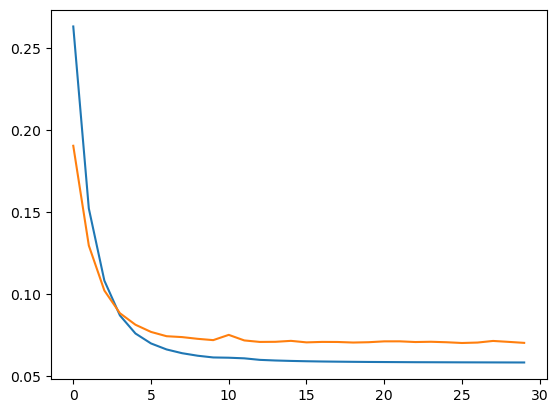

In [32]:
plt.plot(loss_train)
plt.plot(loss_val)
plt.show()

In [33]:
def output_check(dataloader, model):
    # check on single training image
    dataiter = iter(dataloader)
    images,gtruth = dataiter.next()
#     # images to device if gpu used
    images = images.to(device)
    # get sample outputs
    output = model(images.float())


    # prep images for display
#     images = images.numpy()
    images = images.detach().cpu().numpy() # convery to numpy
    images= np.moveaxis(images, 1,-1) # shift channel to last axis for display
    
    # prep output for display
#     output = output.detach().numpy() # convery to numpy - need to detach first
    output = output.squeeze().detach().cpu().numpy() # convery to numpy - need to detach first
    # output = np.moveaxis(output, 1,-1) # shift channel to last axis for display
    
    gtruth = gtruth.squeeze().detach().cpu().numpy() # convery to numpy
    # gtruth= np.moveaxis(gtruth, 1,-1) # shift channel to last axis for display
    
    
    return images, output, gtruth

In [34]:
def output_check_plot(model, train_dl, val_dl, img_choice):
    
    train_imgs, train_out, train_gt = output_check(train_dl, model)
    val_imgs, val_out, val_gt = output_check(val_dl, model)
    
    fig, ax = plt.subplots(2, 3, figsize=(10, 10))
    ax[0,0].imshow(train_imgs[img_choice])
    ax[0,1].imshow(train_out[img_choice])
    ax[0,2].imshow(train_gt[img_choice])

    ax[1,0].imshow(val_imgs[img_choice])
    ax[1,1].imshow(val_out[img_choice])
    ax[1,2].imshow(val_gt[img_choice])
    
    plt.tight_layout()
    plt.show()    

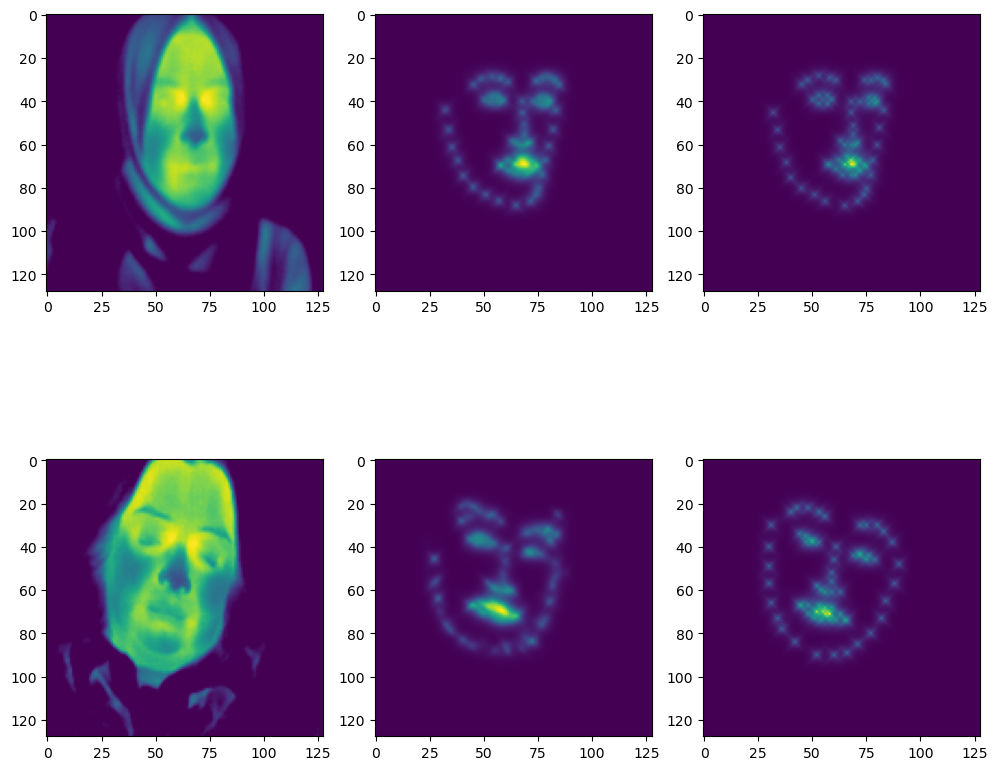

In [35]:
output_check_plot(model_unet, train_dl, val_dl, 3)

In [36]:
# save model
model_save_path = './models/UNet_Basic_v05_init.pt'
torch.save({'model_state_dict': model_unet.state_dict(), 
            'optimizer_state_dict': optimiser_unet.state_dict(),
           }, model_save_path)

# Prep data for MLP

In [37]:
def Landmark1DTensor(landmarks_list):
    """convert list of list of tuples to list of lists"""
    out_list = []
    for lms in landmarks_list:
        # convert list of tuples to single list
        out = [item for t in lms for item in t]
        # append to list for each image
        out_list.append(out)
    return torch.tensor(out_list)

In [38]:
# mlp_gtruth_train = Landmark1DTensor(landmarks_list_train)

# train_dl_no_shuffle = DataLoader(train_ds, batch_size=32, shuffle=False)


In [39]:
def UNet_output_gen(model, data_loader, device = torch.device("cpu")):
    
    model.eval() # set to evaluation mode.     
    output_list = []
    
    with torch.no_grad(): # no backpropagation/ weight updates!
        for batch in data_loader:
            images, gtruth = batch
            images = images.to(device)
            gtruth = gtruth.to(device)
            output = model(images.float()) 
            
            # try sending to cpu before saving to list            
            output = output.to("cpu")
            
            output_list.append(output)
            
            # empty cache on gpu for each mini-batch
            torch.cuda.empty_cache()


    return output_list

In [40]:
import gc

gc.collect()
torch.cuda.empty_cache()

In [41]:
# generate gtruth 1d tensor
mlp_gtruth_train = Landmark1DTensor(lmarks_train)
# data loader to pass training data through Unet without shuffle
train_dl_no_shuffle = DataLoader(train_ds, batch_size=32, shuffle=False)
# pass training data through Unet
unet_out_train = UNet_output_gen(model_unet, train_dl_no_shuffle, device=device)

In [42]:
len(unet_out_train)

188

In [43]:
gc.collect()
torch.cuda.empty_cache()

In [44]:
mlp_in_train = torch.cat(unet_out_train)

In [45]:
# generate mlp data loader
train_ds_mlp = torch.utils.data.TensorDataset(mlp_in_train, mlp_gtruth_train)
train_dl_mlp = DataLoader(train_ds_mlp, batch_size=32, shuffle=True)
print(mlp_gtruth_train.shape)
print(mlp_in_train.shape)

torch.Size([5995, 136])
torch.Size([5995, 1, 128, 128])


In [46]:
# generate gtruth 1d tensor
mlp_gtruth_val = Landmark1DTensor(lmarks_val)
# data loader to pass training data through Unet without shuffle
val_dl_no_shuffle = DataLoader(val_ds, batch_size=32, shuffle=False)
# pass training data through Unet
unet_out_val = UNet_output_gen(model_unet, val_dl_no_shuffle, device=device)

In [47]:
gc.collect()
torch.cuda.empty_cache()

In [48]:
# convert output to tensor from list of tensors
mlp_in_val = torch.cat(unet_out_val)

In [49]:
# generate mlp data loader
val_ds_mlp = torch.utils.data.TensorDataset(mlp_in_val, mlp_gtruth_val)
# again try without shuffle for validation to be able to match data later
val_dl_mlp = DataLoader(val_ds_mlp, batch_size=32, shuffle=False)
print(mlp_gtruth_val.shape)
print(mlp_in_val.shape)

torch.Size([1497, 136])
torch.Size([1497, 1, 128, 128])


In [50]:
# generate gtruth 1d tensor
mlp_gtruth_test = Landmark1DTensor(lmarks_test)
# data loader to pass test data through Unet without shuffle
test_dl_no_shuffle = DataLoader(test_ds, batch_size=32, shuffle=False)
# pass test data through Unet
unet_out_test = UNet_output_gen(model_unet, test_dl_no_shuffle, device=device)

In [51]:
gc.collect()
torch.cuda.empty_cache()

In [52]:
# convert output to tensor from list of tensors
mlp_in_test = torch.cat(unet_out_test)

In [53]:
# generate mlp data loader
test_ds_mlp = torch.utils.data.TensorDataset(mlp_in_test, mlp_gtruth_test)
# again try without shuffle for test to be able to match data later
test_dl_mlp = DataLoader(test_ds_mlp, batch_size=32, shuffle=False)
print(mlp_gtruth_test.shape)
print(mlp_in_test.shape)

torch.Size([1633, 136])
torch.Size([1633, 1, 128, 128])


# Define MLP

In [54]:
# 81920 = 256x320
# 16384 = 128x128
    
class MLP(nn.Module):
    def __init__(self, fc_layers=(1024, 136)):
        super().__init__()
        self.fc_layers         = fc_layers
        self.fc1 = nn.Linear(16384, fc_layers[0])
        self.fc2 = nn.Linear(fc_layers[0], fc_layers[1])
        
    def forward(self, x):
        x = x.view(-1, 16384)
        x = F.sigmoid(self.fc1(x))
        x = self.fc2(x)

        return x

In [55]:
gc.collect()
torch.cuda.empty_cache()

# Train MLP

In [56]:
model_mlp = MLP()
model_mlp.to(device)
train_loader_mlp = train_dl_mlp
val_loader_mlp = val_dl_mlp

# specify loss function
loss_fn_mlp = torch.nn.MSELoss()
# specify optimiser
optimiser = torch.optim.Adam(model_mlp.parameters(), lr=0.0001)

# number of epochs to train the model
n_epochs = 15

loss_train = []
loss_val = []

for epoch in range(1, n_epochs+1):
    model_train(model_mlp, train_loader_mlp, optimiser, loss_fn_mlp, loss_train, device = device)
    model_eval(model_mlp, val_loader_mlp, loss_fn_mlp, loss_val, device = device)

    print(f'Epoch: {epoch}|Loss (train): {loss_train[-1]:.3f}| Loss (val): {loss_val[-1]:.3f}')

C:\Users\stevenmcd\anaconda3\envs\pytorch\lib\site-packages\torch\nn\functional.py:1805: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


Epoch: 1|Loss (train): 2667.309| Loss (val): 1582.802
Epoch: 2|Loss (train): 1174.539| Loss (val): 667.302
Epoch: 3|Loss (train): 515.458| Loss (val): 276.468
Epoch: 4|Loss (train): 230.250| Loss (val): 123.068
Epoch: 5|Loss (train): 116.697| Loss (val): 71.447
Epoch: 6|Loss (train): 76.518| Loss (val): 57.286
Epoch: 7|Loss (train): 64.067| Loss (val): 54.485
Epoch: 8|Loss (train): 60.502| Loss (val): 54.451
Epoch: 9|Loss (train): 59.597| Loss (val): 54.738
Epoch: 10|Loss (train): 59.339| Loss (val): 54.760
Epoch: 11|Loss (train): 58.041| Loss (val): 51.749
Epoch: 12|Loss (train): 50.193| Loss (val): 40.809
Epoch: 13|Loss (train): 44.678| Loss (val): 38.688
Epoch: 14|Loss (train): 42.099| Loss (val): 37.797
Epoch: 15|Loss (train): 40.437| Loss (val): 36.988


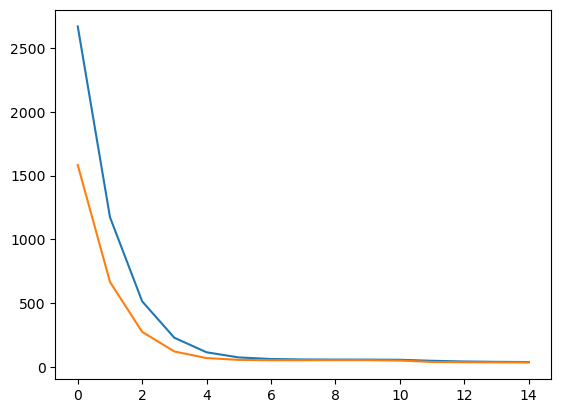

In [57]:
plt.plot(loss_train)
plt.plot(loss_val)
plt.show()

In [58]:
def model_predict(model, data_loader, device = torch.device("cpu")):
    model.to(device)
    model.eval() # set to evaluation mode. 

    images_list = []
    gtruth_list = []
    output_list = []    
    
    with torch.no_grad(): # no backpropagation/ weight updates!
        for batch in data_loader:
            images, gtruth = batch
            images = images.to(device)
            gtruth = gtruth.to(device)
            preds = model(images.float())
            # print(preds.shape)
            images_list.append(images)
            gtruth_list.append(gtruth)
            output_list.append(preds)

    images_tensor = torch.cat(images_list)
    gtruth_tensor = torch.cat(gtruth_list)
    output_tensor = torch.cat(output_list)

    return images_tensor, gtruth_tensor, output_tensor

# Check results on validation set

In [59]:
train_images, train_gtruth, train_output = model_predict(model_mlp, train_dl_mlp)

In [60]:
gc.collect()
torch.cuda.empty_cache()

In [61]:
val_images, val_gtruth, val_output = model_predict(model_mlp, val_dl_mlp)

In [62]:
test_images, test_gtruth, test_output = model_predict(model_mlp, test_dl_mlp)

In [63]:
def MLP_output_plot(images, gtruth, output, img, nrows, ncols):
    fig, ax = plt.subplots(nrows = nrows, ncols=ncols, figsize=(ncols+8, nrows+8))
    idx_plt = 0
    for row in range(nrows):
        for col in range(ncols):
            image_lm = images[img+idx_plt].detach().cpu().numpy()
            gtruth_lm = gtruth[img+idx_plt].detach().cpu().numpy()
            output_lm = output[img+idx_plt].detach().cpu().numpy()

            image_lm = image_lm.squeeze()
            image = np.zeros((128, 128, 3), dtype=np.uint8)
            image[:,:,0] = image_lm*255
            image[:,:,1] = image_lm*255
            image[:,:,2] = image_lm*255

            lmarks_ou = []
            for i, val in enumerate(output_lm):
                if (i % 2) == 0:
                    x = output_lm[i]
                    y = output_lm[i+1]  
                    lmarks_ou.append([x,y])
            l_map_ou = np.zeros([128,128])
            for l in lmarks_ou:
                j = int(l[0]) -1
                i = int(l[1]) -1
                if i > 127:
                    i = 127
                if j > 127:
                    j = 127
                l_map_ou[i,j] = 1
                image = cv2.circle(image, (j, i), 1, (255, 0, 0), -1)
            
            lmarks_gt = []
            for i, val in enumerate(gtruth_lm):
                if (i % 2) == 0:
                    x = gtruth_lm[i]
                    y = gtruth_lm[i+1]  
                    lmarks_gt.append([x,y])   
            l_map_gt = np.zeros([128,128])
            for l in lmarks_gt:
                j = int(l[0] - 1)
                i = int(l[1] - 1)
                if i > 127:
                    i = 127
                if j > 127:
                    j = 127
                l_map_gt[i,j] = 1
                image = cv2.circle(image, (j, i), 1, (0, 255, 0), -1)

            ax[row, col].imshow(image)

            idx_plt+= 1

    plt.tight_layout()
    plt.show() 

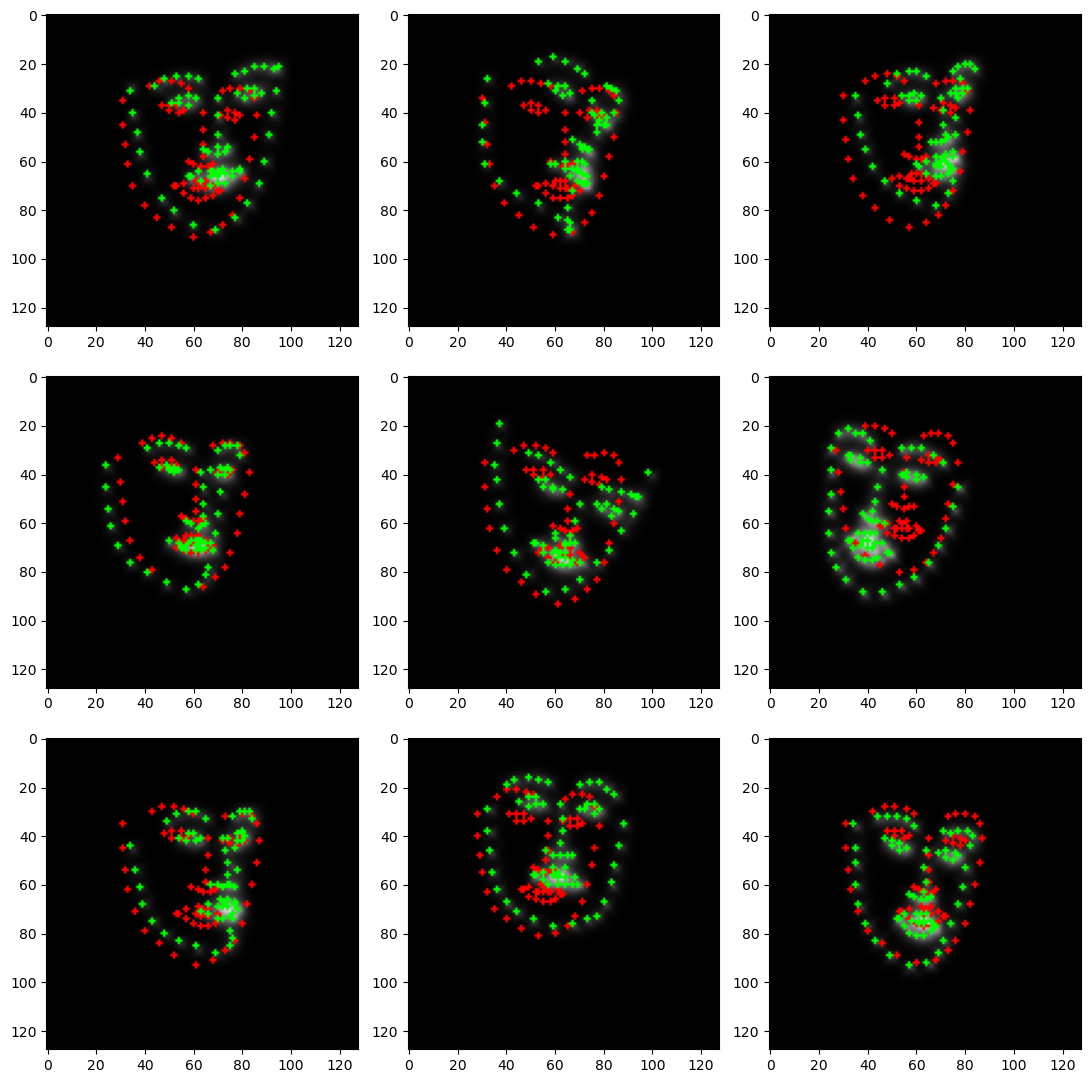

In [64]:
MLP_output_plot(train_images, train_gtruth, train_output, 200, 3, 3)

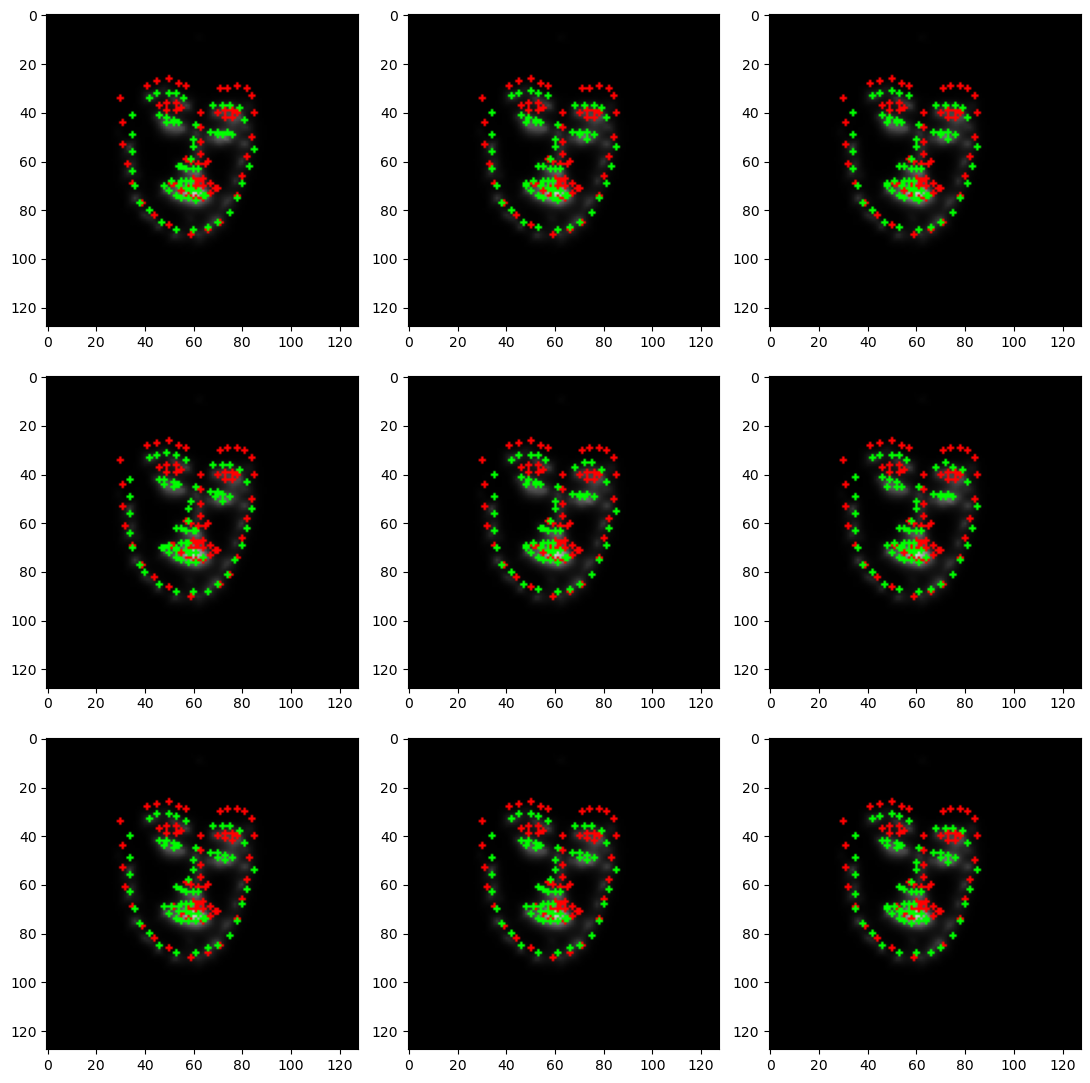

In [65]:
MLP_output_plot(val_images, val_gtruth, val_output, 200, 3, 3)

In [66]:
def MLP_image_output_plot(images, gtruth, output, img, nrows, ncols):
    fig, ax = plt.subplots(nrows = nrows, ncols=ncols, figsize=(ncols+8, nrows+8))
    idx_plt = 0
    for row in range(nrows):
        for col in range(ncols):
            image = images[img+idx_plt].copy()
            gtruth_lm = gtruth[img+idx_plt].detach().cpu().numpy()
            output_lm = output[img+idx_plt].detach().cpu().numpy()

            lmarks_ou = []
            for i, val in enumerate(output_lm):
                if (i % 2) == 0:
                    x = output_lm[i]
                    y = output_lm[i+1]  
                    lmarks_ou.append([x,y])
            l_map_ou = np.zeros([128,128])
            for l in lmarks_ou:
                j = int(l[0]) -1
                i = int(l[1]) -1
                if i > 128:
                    i = 128
                if j > 128:
                    j = 128
                l_map_ou[i,j] = 1
                image = cv2.circle(image, (j, i), 1, (255, 0, 0), -1)
            
            lmarks_gt = []
            for i, val in enumerate(gtruth_lm):
                if (i % 2) == 0:
                    x = gtruth_lm[i]
                    y = gtruth_lm[i+1]  
                    lmarks_gt.append([x,y])   
            l_map_gt = np.zeros([128,128])
            for l in lmarks_gt:
                j = int(l[0] - 1)
                i = int(l[1] - 1)
                if i > 128:
                    i = 128
                if j > 128:
                    j = 128
                l_map_gt[i,j] = 1
                image = cv2.circle(image, (j, i), 1, (0, 255, 0), -1)

            ax[row, col].imshow(image)

            idx_plt+= 1

    plt.tight_layout()
    plt.show() 

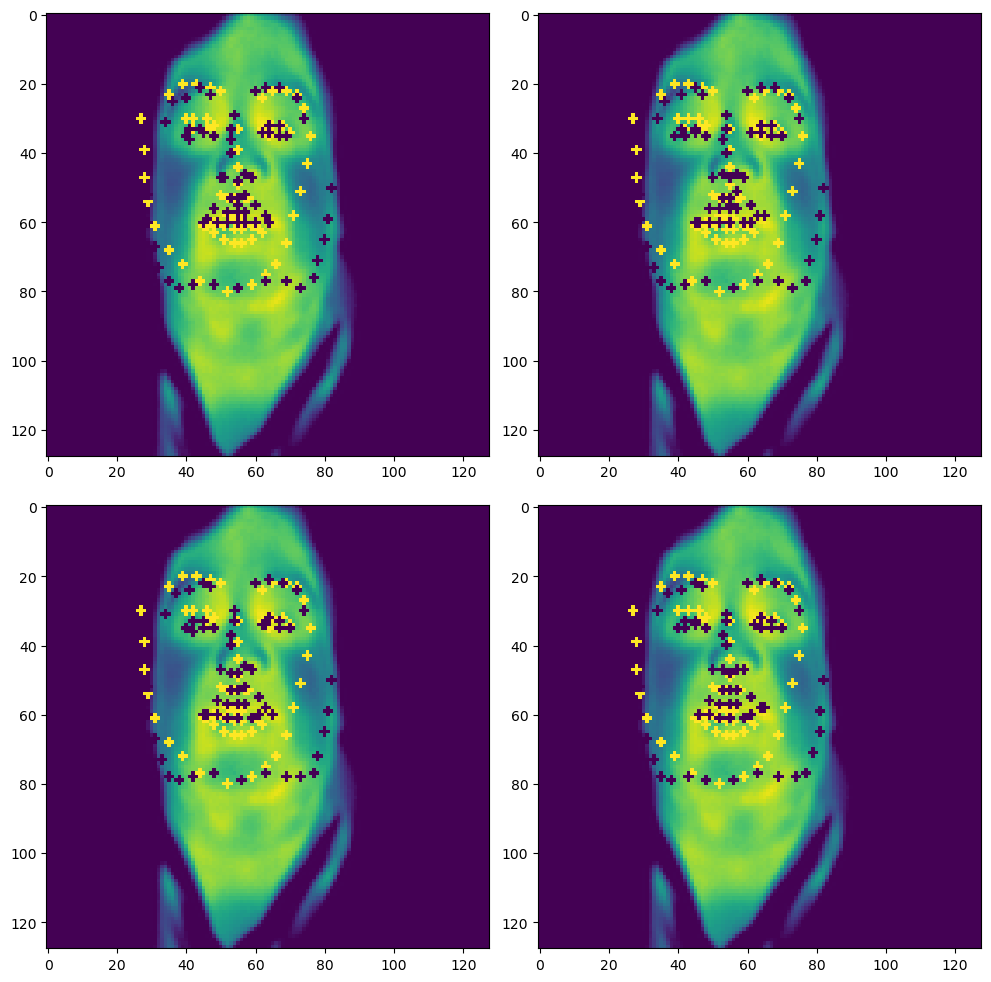

In [67]:
MLP_image_output_plot(images_val, val_gtruth, val_output, 1400, 2, 2)

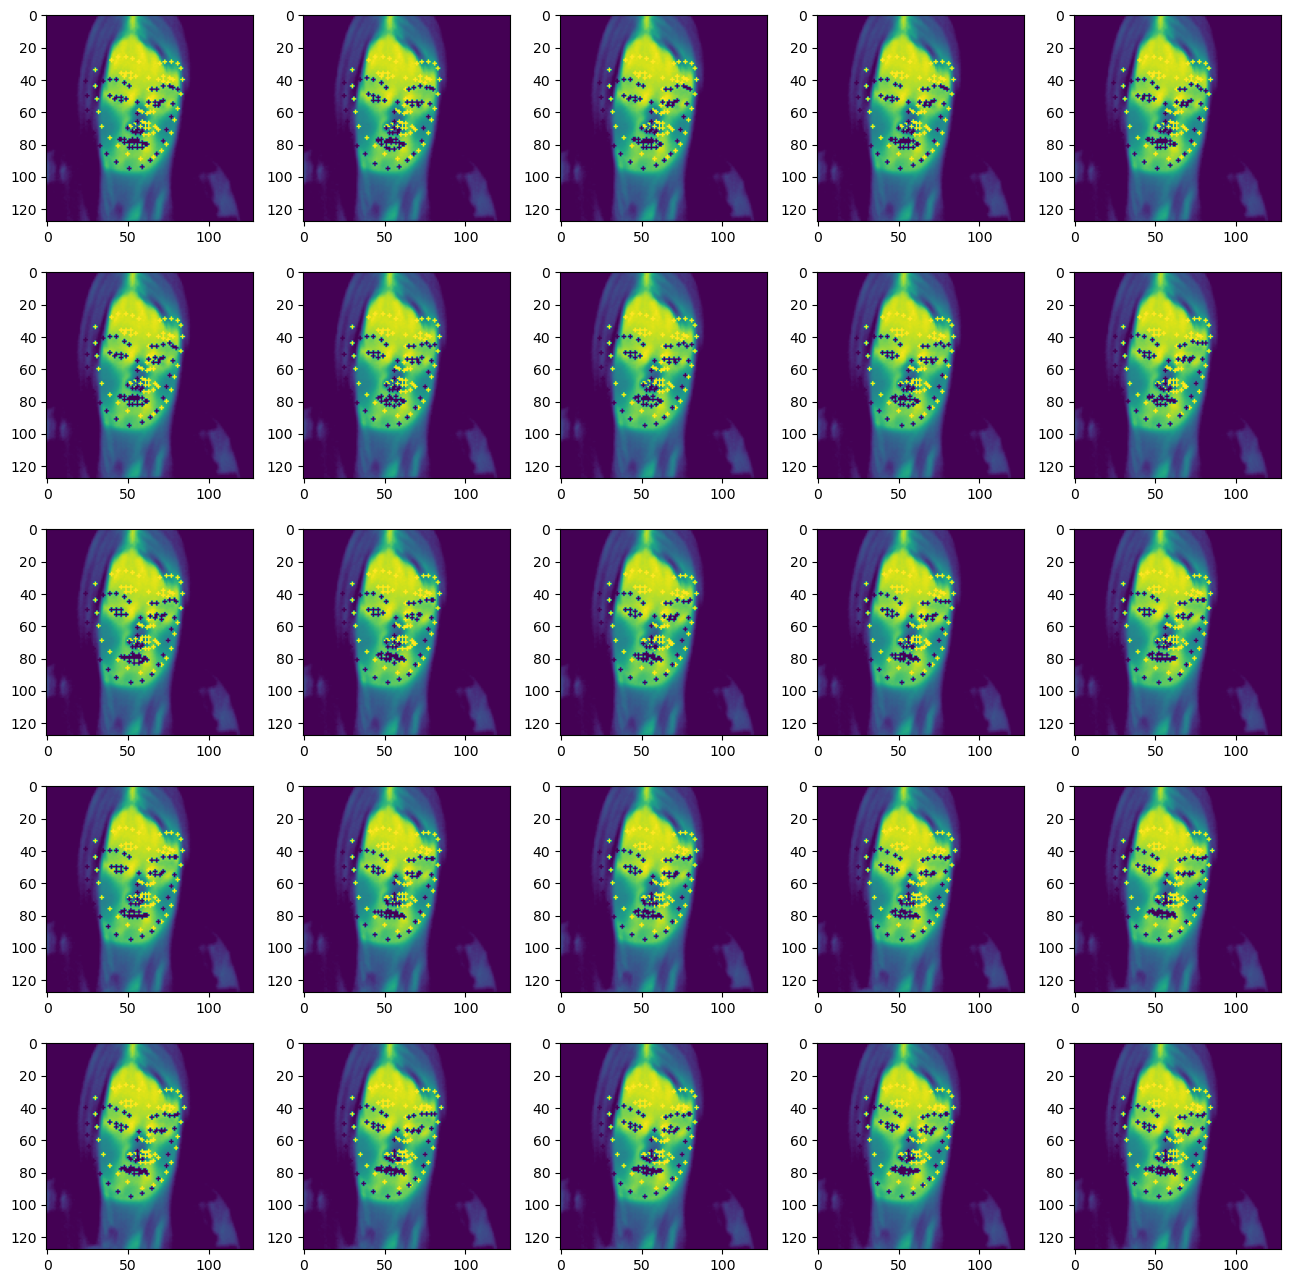

In [68]:
MLP_image_output_plot(images_test, test_gtruth, test_output, 500, 5, 5)

# Calculate Errors

In [69]:
def Tensor2Landmarks(lm_tensor):
    lm_np = lm_tensor.detach().cpu().numpy()
    # print(lm_np)
    lm_list = []
    for i in range(68):
        lm = [lm_np[i*2],lm_np[(i*2)+1]]
        lm_list.append(lm)
    return lm_list

In [70]:
def landmark_error(gtruth_lms, pred_lms):
    K = len(gtruth_lms)
    # print('K:', K)
    leye_gt = gtruth_lms[36:42]
    reye_gt = gtruth_lms[42:48]
    leye_gt_centre = np.array(leye_gt).mean(axis=0)
    reye_gt_centre = np.array(reye_gt).mean(axis=0)
    Di = np.linalg.norm(leye_gt_centre-reye_gt_centre)
    # print('Di:', Di)
    dist_sum = 0
    for i, lms in enumerate(gtruth_lms):
        gt = np.array(gtruth_lms[i])
        pred = np.array(pred_lms[i])
        dist = np.linalg.norm(gt-pred)
        dist_sum += dist
    #     print(i, dist)
    #     print(lmarks_1[i], lmarks_2[i])

    lm_err = dist_sum/(K*Di)
    # print('lm_err', lm_err)
    return lm_err    

In [71]:
def landmark_error_all(val_gtruth, val_output):
    lm_err_list = []
    for i in range(len(val_gtruth)):
        gtruth = Tensor2Landmarks(val_gtruth[i])
        output = Tensor2Landmarks(val_output[i])
        lm_err = landmark_error(gtruth, output)
        lm_err_list.append(lm_err)
    return lm_err_list

In [72]:
lm_err_train_list = landmark_error_all(train_gtruth, train_output)
np.mean(lm_err_train_list)

0.32633935368870676

In [73]:
lm_err_val_list = landmark_error_all(val_gtruth, val_output)
np.mean(lm_err_val_list)

0.3446443344537003

In [74]:
lm_err_test_list = landmark_error_all(test_gtruth, test_output)
np.mean(lm_err_test_list)

0.36365899746541475